In [1]:
import torch

def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')

    return device

device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [4]:
if IN_COLAB:
    PATH_TO_DATA = '/content/'
else:
    PATH_TO_DATA = './data/'

# Copy data 

In [5]:
BASE_PATH = '/content/drive/MyDrive/ai/detect-flood-water/'

In [6]:
!ls {BASE_PATH}

cv_results.ipynb	    flood-train-images.tgz	 pth_save
detect-flood-water	    flood-training-metadata.csv  training_results.ipynb
flood-train-images-aux.tgz  flood-train-labels.tgz


In [7]:
%%time
file_name = 'flood-train-images.tgz'
file_path = BASE_PATH + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xvf {local_path} > /dev/null

CPU times: user 126 ms, sys: 46.2 ms, total: 172 ms
Wall time: 14.6 s


In [8]:
%%time
file_name = 'flood-train-labels.tgz'
file_path = BASE_PATH + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xvf {local_path} > /dev/null

CPU times: user 13.1 ms, sys: 13.3 ms, total: 26.4 ms
Wall time: 427 ms


In [9]:
file_name = 'flood-training-metadata.csv'
file_path = BASE_PATH + file_name

!cp {file_path} .

# Install libs

In [10]:
!pip install ttach
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install rasterio
!pip install pandas_path
!pip install segmentation_models_pytorch

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-unb20iwj
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-unb20iwj
     |████████████████████████████████| 37.1 MB 65.3 MB/s 
  Created wheel for albumentations: filename=albumentations-1.0.3-py3-none-any.whl size=102041 sha256=3eab8294e401140c023b4241155b3972160e660ceacb76e4cec896d9a6d12eb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-uwhjkp_v/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 19.3 MB 44 kB/s 
     |████████████████████████████████| 87 kB 3.3 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
     |████████████████████████████████| 376 kB 26.2 MB/s 
  Created wheel for ef

# Imports

In [11]:
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [12]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [13]:
os.chdir("/content/drive/My Drive/ai/detect-flood-water/detect-flood-water/")

In [14]:
from utils import seed_everything

In [15]:
seed = 2021
seed_everything(seed)

In [16]:
import warnings

warnings.filterwarnings("ignore")

In [17]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

# Git repo 

In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   data.py
	modified:   detect-flood-water-cv.ipynb
	modified:   detect-flood-water-train.ipynb
	modified:   transform.py

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
# !git diff train.py

In [ ]:
!git add .

In [ ]:
!git config --global user.email "michael.kalinin.nn@gmail.com"
!git config --global user.name "michaelka"

In [ ]:
!git commit -m "[colab] Run CV 2"

[master 7ee1bb7] [colab] Run CV 2
 4 files changed, 11 insertions(+), 9 deletions(-)
 rewrite detect-flood-water-cv.ipynb (92%)


In [ ]:
!git push origin master

Counting objects: 6, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 373.56 KiB | 11.32 MiB/s, done.
Total 6 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/MIchaelKa/detect-flood-water.git
   d7e3573..7ee1bb7  master -> master


# CV

In [18]:
from main import run_cv

In [19]:
encoder_name = 'timm-efficientnet-b0' # timm-efficientnet-b0
model_name = 'unet'

In [20]:
scheduler_params = dict(
    name = 'MultiStepLR', # MultiStepLR OneCycleLR None

    # MultiStepLR
    milestones = [1, 2, 3],
    gamma = 0.5,
)

debug_params = dict(
    reduce_train=True,
    train_number=20,
    valid_number=4,

    batch_size_train=2,
    batch_size_valid=2,
    max_iter=5,
    unfreeze_iter=0,
    valid_iters=[1, 3, 4],
    
    scheduler_params=scheduler_params,
    
    encoder_name = encoder_name,
    save_model=True,
    model_save_name='test_model',
)

In [21]:
max_iter=480
valid_step=30
unfreeze_iter=0 # 90

valid_iters = list(np.arange(valid_step-1, max_iter, valid_step))
valid_iters

[29, 59, 89, 119, 149, 179, 209, 239, 269, 299, 329, 359, 389, 419, 449, 479]

In [22]:
scheduler_params = dict(
    name = 'None', # MultiStepLR OneCycleLR None

    # MultiStepLR
    milestones = [300],
    gamma = 0.4,
    
    # OneCycleLR
    max_lr = 0.3,
    pct_start = 0.3,
)

full_params = dict(
    reduce_train=False,
    train_number=0,
    valid_number=0,
    
    batch_size_train=32,
    batch_size_valid=32,
    max_iter=max_iter,
    unfreeze_iter=unfreeze_iter,
    # valid_iters=valid_iters

    preprocess_input=False,
    crop_size=256,
    
    scheduler_params=scheduler_params,
    
    save_model=True,
    model_save_name=f'{model_name}_{encoder_name}_27.09_CV_0'
)

In [23]:
params = dict(
    path_to_data=PATH_TO_DATA,

    optimizer_name='Adam',
    learning_rate=3e-4, # 5e-4, 3e-4, 1e-3
    weight_decay=0,
    dice_ratio=0,

    verbose=True,

    encoder_name=encoder_name,
)

params.update(full_params) # full_params, debug_params

In [24]:
params

{'batch_size_train': 32,
 'batch_size_valid': 32,
 'crop_size': 256,
 'dice_ratio': 0,
 'encoder_name': 'timm-efficientnet-b0',
 'learning_rate': 0.0003,
 'max_iter': 480,
 'model_save_name': 'unet_timm-efficientnet-b0_27.09_CV_0',
 'optimizer_name': 'Adam',
 'path_to_data': '/content/',
 'preprocess_input': False,
 'reduce_train': False,
 'save_model': True,
 'scheduler_params': {'gamma': 0.4,
  'max_lr': 0.3,
  'milestones': [300],
  'name': 'None',
  'pct_start': 0.3},
 'train_number': 0,
 'unfreeze_iter': 0,
 'valid_number': 0,
 'verbose': True,
 'weight_decay': 0}

In [25]:
other_params = dict(
    valid_iters=valid_iters,
#     scheduler_params=scheduler_params
)
params.update(other_params)

In [26]:
# Do not foget update model_save_name!
train_infos = run_cv(device, **params)

[run_cv]
['kuo', 'tht', 'qus']
['hbe', 'awc']
['tnp', 'wvy', 'qxb']
['pxs', 'ayt', 'jja']
['hxu', 'coz']

[data] fold: 0, flood_ids: ['kuo', 'tht', 'qus']
[data] Dataset size, train: 417, valid: 125, ratio: 23.062730627306273

[data] train_transform:
Compose([
  RandomCrop(always_apply=False, p=1.0, height=256, width=256),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


[data] features: ['vv', 'vh']
[data] DataLoader size, train: 14, valid: 4
[data] num_epoch: 34.285714285714285, num_train_samples: 15360


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

[train] started...
[train] iter:   29, loss = 0.43288, score = 0.38776, time: 0:00:46
[valid] iter:   29, loss = 1.16105, score = 0.09539, time: 0:00:46
[valid] iter:   29, score = {'kuo': 0.01771688088774681, 'qus': 0.2438931167125702, 'tht': 0.2339714765548706}

[train] iter:   59, loss = 0.34416, score = 0.48366, time: 0:01:26
[valid] iter:   59, loss = 0.20148, score = 0.50263, time: 0:01:26
[valid] iter:   59, score = {'kuo': 0.17556579411029816, 'qus': 0.6010127067565918, 'tht': 0.5938544273376465}

[train] iter:   89, loss = 0.29209, score = 0.53717, time: 0:02:06
[valid] iter:   89, loss = 0.15201, score = 0.71425, time: 0:02:06
[valid] iter:   89, score = {'kuo': 0.28828731179237366, 'qus': 0.839176595211029, 'tht': 0.7545058131217957}

[train] iter:  119, loss = 0.26660, score = 0.57442, time: 0:02:46
[valid] iter:  119, loss = 0.14442, score = 0.67389, time: 0:02:46
[valid] iter:  119, score = {'kuo': 0.2269866168498993, 'qus': 0.8511075973510742, 'tht': 0.7106119394302368}


### Train info

In [27]:
len(train_infos)

5

In [28]:
from plot_utils import show_train_metrics, show_loss_and_score, show_valid_score_by_flood

In [29]:
train_info = train_infos[0]

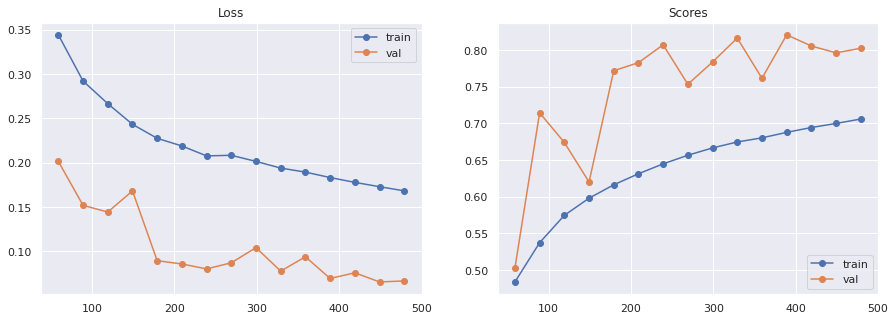

In [30]:
# show_loss_and_score(train_info)
show_loss_and_score(train_info, start_from=1)

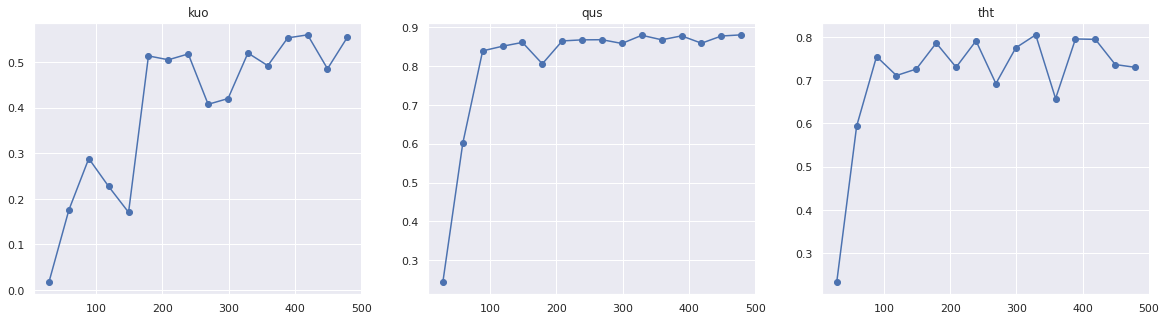

In [31]:
show_valid_score_by_flood(train_info)

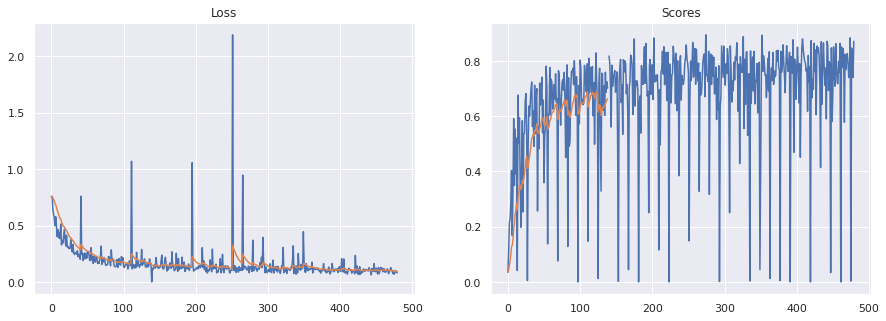

In [32]:
loss_meter = train_info['train_loss_meter']
score_meter = train_info['train_score_meter']
show_train_metrics(loss_meter, score_meter)

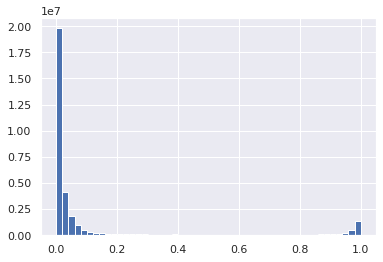

In [33]:
valid_outputs = train_info['valid_outputs']
plt.hist(np.concatenate(valid_outputs), bins=50)
plt.show()

In [34]:
train_info = train_infos[1]

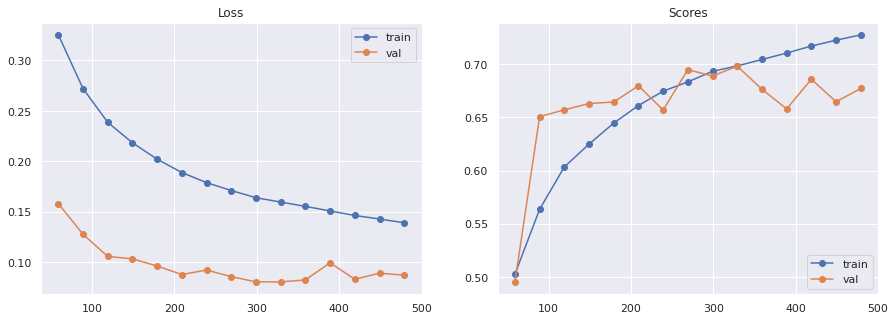

In [35]:
# show_loss_and_score(train_info)
show_loss_and_score(train_info, start_from=1)

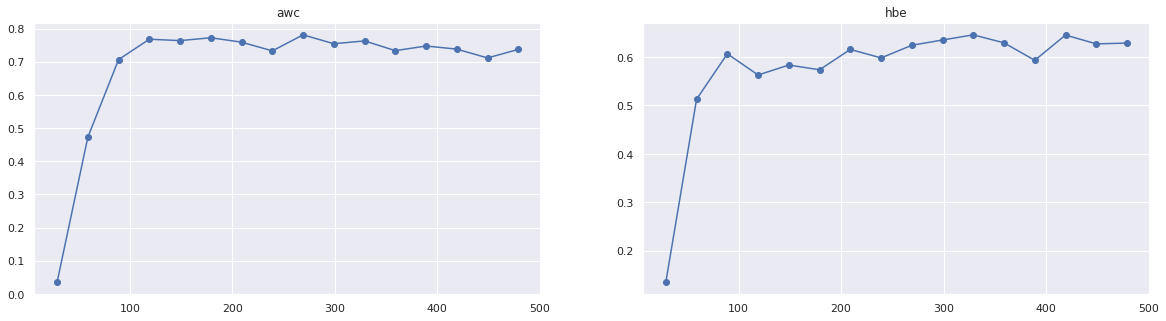

In [36]:
show_valid_score_by_flood(train_info)

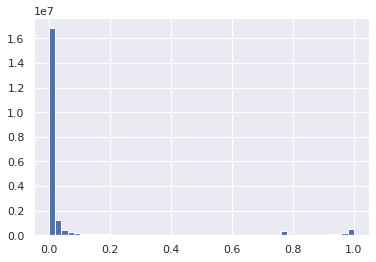

In [37]:
valid_outputs = train_info['valid_outputs']
plt.hist(np.concatenate(valid_outputs), bins=50)
plt.show()

In [38]:
train_info = train_infos[2]

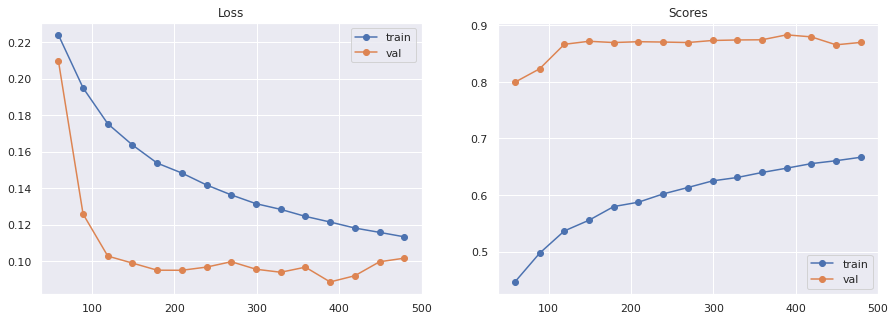

In [39]:
# show_loss_and_score(train_info)
show_loss_and_score(train_info, start_from=1)

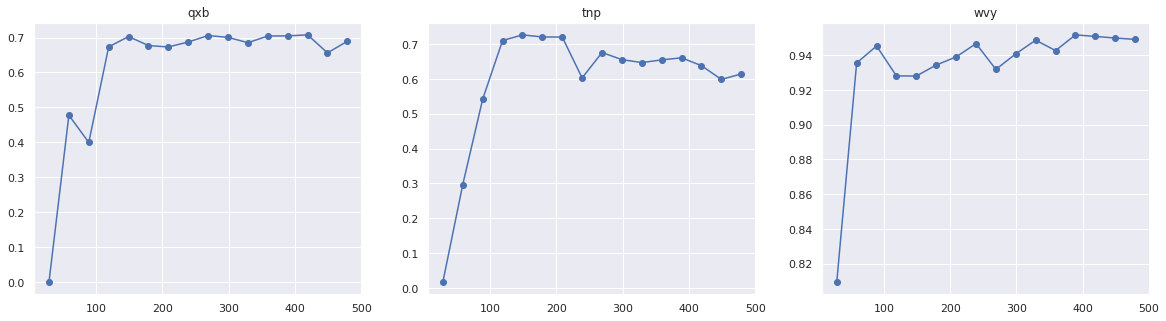

In [40]:
show_valid_score_by_flood(train_info)

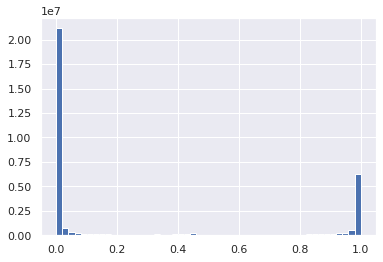

In [41]:
valid_outputs = train_info['valid_outputs']
plt.hist(np.concatenate(valid_outputs), bins=50)
plt.show()

In [42]:
train_info = train_infos[3]

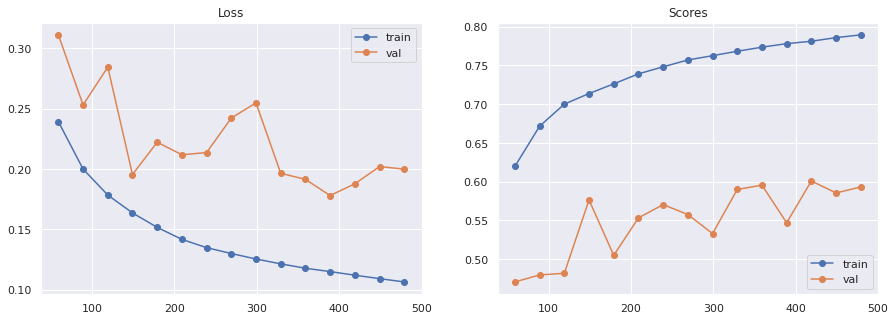

In [43]:
# show_loss_and_score(train_info)
show_loss_and_score(train_info, start_from=1)

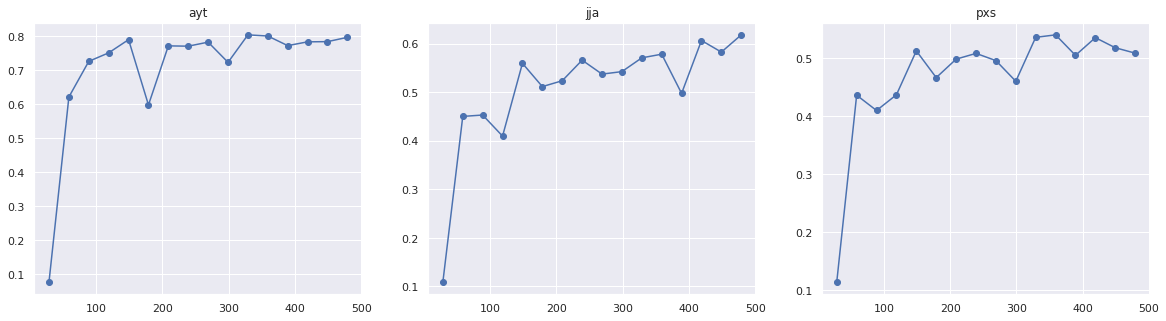

In [44]:
show_valid_score_by_flood(train_info)

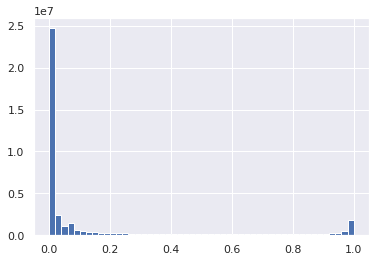

In [45]:
valid_outputs = train_info['valid_outputs']
plt.hist(np.concatenate(valid_outputs), bins=50)
plt.show()

In [46]:
train_info = train_infos[4]

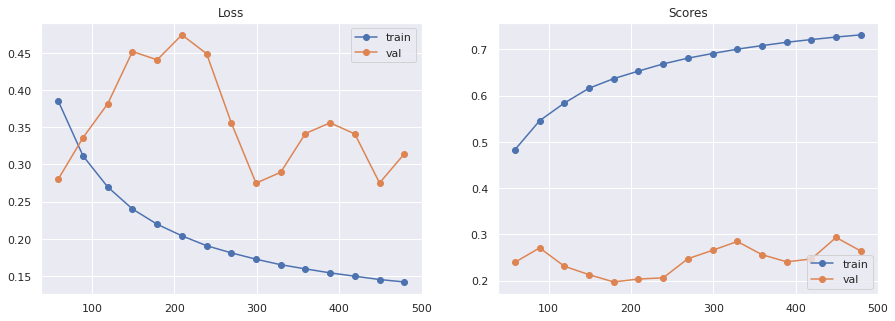

In [47]:
# show_loss_and_score(train_info)
show_loss_and_score(train_info, start_from=1)

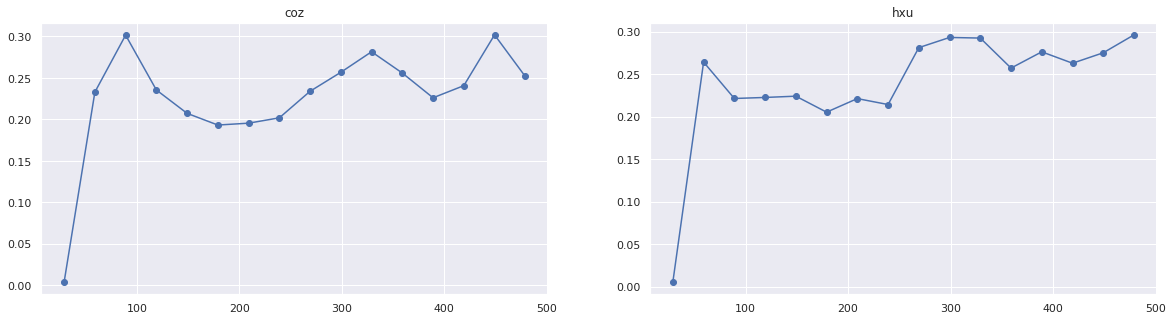

In [48]:
show_valid_score_by_flood(train_info)

# Validation

In [49]:
from model import get_model, get_model_tta
from dataset import FloodDataset
from data import get_data_by_flood_id
from train import validate

import torch
import torch.nn as nn

from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [97]:
import pandas as pd

In [50]:
os.listdir('pth')

['cv_11.09',
 'cv_24.09',
 'unet_timm-efficientnet-b0_27.09_CV_0_fold_0.pth',
 'unet_timm-efficientnet-b0_27.09_CV_0_fold_1.pth',
 'unet_timm-efficientnet-b0_27.09_CV_0_fold_2.pth',
 'unet_timm-efficientnet-b0_27.09_CV_0_fold_3.pth',
 'unet_timm-efficientnet-b0_27.09_CV_0_fold_4.pth',
 'cv_27.09']

In [70]:
loss = nn.CrossEntropyLoss(
    ignore_index=255,
    reduction='none'
)

In [134]:
cv = 'cv_24.09'

In [135]:
models = os.listdir(f'pth/{cv}')
models

['unet_timm-efficientnet-b0_24.09_CV_0_fold_0.pth',
 'unet_timm-efficientnet-b0_24.09_CV_0_fold_1.pth',
 'unet_timm-efficientnet-b0_24.09_CV_0_fold_2.pth',
 'unet_timm-efficientnet-b0_24.09_CV_0_fold_3.pth']

In [136]:
folds = [
    ['kuo', 'tht', 'qus'],
    ['hxu', 'hbe', 'awc'],
    ['tnp', 'wvy', 'qxb'],
    ['pxs', 'ayt', 'coz', 'jja']
]

# folds = [
#     ['kuo', 'tht', 'qus'],
#     ['hbe', 'awc'],
#     ['tnp', 'wvy', 'qxb'],
#     ['pxs', 'ayt', 'jja'],
#     ['coz', 'hxu'],
# ]



In [137]:
threshold = 0.5

In [138]:
cv_scores = []

features = ['vv', 'vh']

chip_ids_all = []
flood_ids_all = []
val_losses_all = []

for model_name, fold in zip(models, folds):
    print(model_name, fold)

    model_base = get_model(encoder_name).to(device)
    model_path = f'pth/{cv}/{model_name}'

    model_base.load_state_dict(torch.load(model_path))
    model_base = model_base.eval()
    # model_base = get_model_tta(model_base)

    model = model_base

    val_x, val_y = get_data_by_flood_id(PATH_TO_DATA, fold)
    valid_dataset = FloodDataset(features, val_x, val_y, transforms=None, preprocessing=None)

    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
    loss_meter, score_meter, outputs, chip_ids, flood_ids, val_losses = validate(
        model, device, valid_loader, loss, threshold=threshold, print_every=1, verbose=False)
    
    chip_ids_all.append(np.concatenate(chip_ids))
    flood_ids_all.append(np.concatenate(flood_ids))
    val_losses_all.append(np.concatenate(val_losses))

    cv_scores.append(score_meter.compute_score().item())

unet_timm-efficientnet-b0_24.09_CV_0_fold_0.pth ['kuo', 'tht', 'qus']
[data] Dataset size: 125
unet_timm-efficientnet-b0_24.09_CV_0_fold_1.pth ['hxu', 'hbe', 'awc']
[data] Dataset size: 110
unet_timm-efficientnet-b0_24.09_CV_0_fold_2.pth ['tnp', 'wvy', 'qxb']
[data] Dataset size: 127
unet_timm-efficientnet-b0_24.09_CV_0_fold_3.pth ['pxs', 'ayt', 'coz', 'jja']
[data] Dataset size: 180


In [139]:
chip_ids_all = np.concatenate(chip_ids_all)
flood_ids_all = np.concatenate(flood_ids_all)
val_losses_all = np.concatenate(val_losses_all)

In [140]:
val_loss_data = pd.DataFrame()
val_loss_data['chip_id'] = chip_ids_all
val_loss_data['flood_id'] = flood_ids_all
val_loss_data['loss'] = val_losses_all

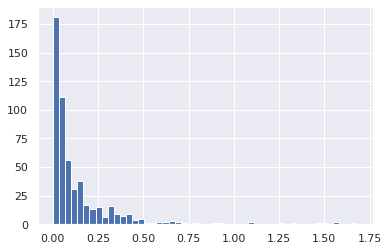

In [141]:
val_loss_data['loss'].hist(bins=50)

In [142]:
val_loss_data_filter = val_loss_data[val_loss_data['loss']>0.4]
val_loss_data_filter.shape

(43, 3)

In [143]:
val_loss_data_filter

,chip_id,flood_id,loss
198,hbe58,hbe,0.557918
224,hxu15,hxu,0.453901
255,qxb20,qxb,0.478771
317,tnp40,tnp,0.446155
323,tnp46,tnp,0.645173
336,wvy06,wvy,0.699143
340,wvy10,wvy,0.496433
368,ayt06,ayt,0.607453
380,coz00,coz,1.324996
381,coz01,coz,0.434838


In [133]:
val_loss_data_filter

,chip_id,flood_id,loss
133,awc08,awc,0.495831
196,hbe56,hbe,0.414048
198,hbe58,hbe,0.530496
224,hxu15,hxu,0.595775
317,tnp40,tnp,0.418185
323,tnp46,tnp,0.611045
336,wvy06,wvy,0.444635
340,wvy10,wvy,0.440989
349,wvy19,wvy,0.414001
368,ayt06,ayt,0.561242


In [122]:
val_loss_data_filter

,chip_id,flood_id,loss
229,qxb20,qxb,0.465889
281,tnp30,tnp,0.416790
297,tnp46,tnp,0.674548
314,wvy10,wvy,0.474445
342,ayt06,ayt,0.651234
357,jja03,jja,0.413147
364,jja10,jja,0.625146
387,jja33,jja,0.823344
388,jja34,jja,1.738047
410,jja56,jja,0.444726


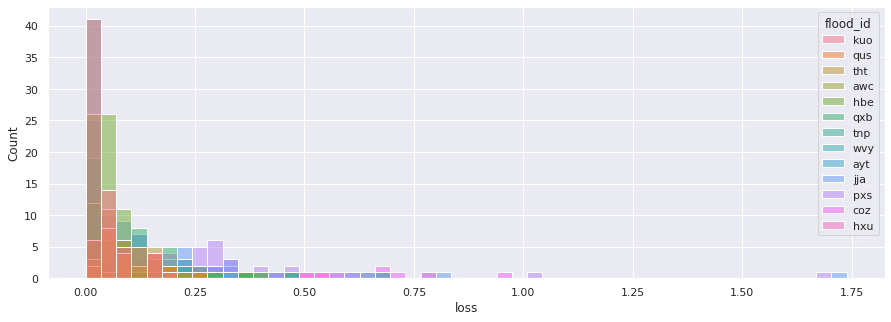

In [118]:
plt.figure(figsize=(15,5))
sns.histplot(data=val_loss_data, x="loss", hue='flood_id', bins=50)

In [65]:
cv_scores = np.array(cv_scores)
print('')
print(f'[run_cv] results: {cv_scores}')
print(f'[run_cv] mean: {cv_scores.mean()}, std: {cv_scores.std()}')


[run_cv] results: [0.82052332 0.69824332 0.88302642 0.6008895  0.29343891]
[run_cv] mean: 0.6592242956161499, std: 0.20728200433690727
